In [1]:
import numpy as np
from helpers import *
import cv2
import matplotlib.pyplot as plt

In [2]:
im1 = cv2.imread("data/im1.jpg")
im2 = cv2.imread("data/im2.jpg")

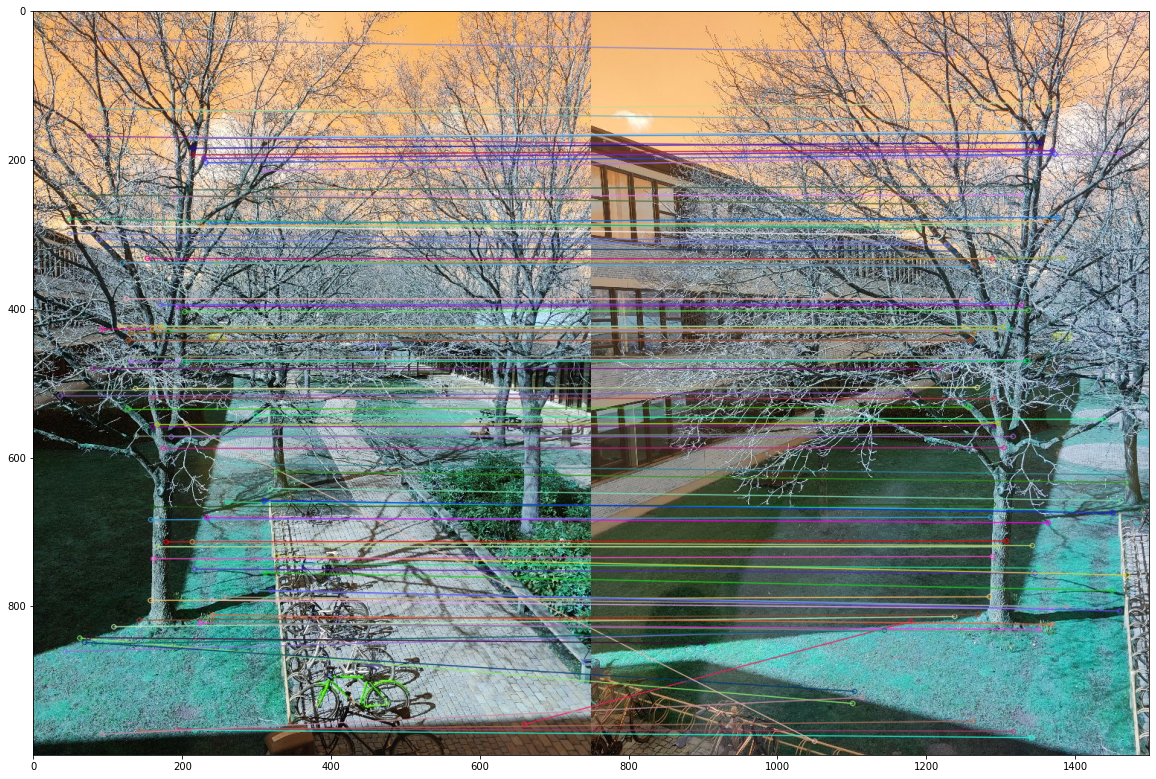

In [3]:
sift = cv2.SIFT_create()
kp, des = sift.detectAndCompute(im1, None)
kp2, des2 = sift.detectAndCompute(im2, None)
bf = cv2.BFMatcher_create(crossCheck=True)
matches = bf.match(des, des2)
matches = sorted(matches, key = lambda x:x.distance)
img3 = cv2.drawMatches(im1,kp,im2,kp2,matches[:100],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (20,20))
plt.imshow(img3)

In [4]:
good = matches[:200] # just a filter, not really necessary but should speed up things
P1 = np.array([[kp2[m.trainIdx].pt[0],kp2[m.trainIdx].pt[1],1] for m in good])
P2 = np.array([[kp[m.queryIdx].pt[0],kp[m.queryIdx].pt[1],1] for m in good])
threshold = (3.84 * 3**2)**2
max_inliers = 0
Hest = None
best_inlier_points = []
inlier_indices = []
niter = 10
for i in range(niter):
    choice  = np.random.choice(good, 4, replace=False)
    points1 = np.array([[kp2[m.trainIdx].pt[0],kp2[m.trainIdx].pt[1],1] for m in choice])
    points2 = np.array([[kp[m.queryIdx].pt[0],kp[m.queryIdx].pt[1],1] for m in choice])
    H, status = cv2.findHomography(points1, points2)
    inliers = 0
    inlier_points = []
    for i,(p1,p2) in enumerate(zip(P1,P2)):
        p1proj = (H @ p1)
        p1proj = p1proj / p1proj[-1]
        p2proj = np.linalg.inv(H) @ p2
        p2proj = p2proj / p2proj[-1]
        d = np.linalg.norm(p2[:2] - p1proj[:2],2)**2 + np.linalg.norm(p1[:2] - p2proj[:2],2)**2
        if d < threshold:
            inliers += 1
            inlier_points.append((p1,p2))
        if inliers > max_inliers:
            max_inliers = inliers
            Hest = H
            best_inlier_points = inlier_points
            inlier_indices.append(i)
best_inlier_points = np.array(best_inlier_points)
Hest, status = cv2.findHomography(best_inlier_points[:,1,:], best_inlier_points[:,0,:])
max_inliers, Hest

(186,
 array([[ 6.02953572e-01, -1.42094576e-02,  4.06495744e+02],
        [-2.57114290e-01,  9.08299642e-01,  4.35737665e+01],
        [-5.48817241e-04,  5.23551973e-06,  1.00000000e+00]]))

In [5]:
Hest = estHomographyRANSAC(kp,des,kp2,des2)
Hest

array([[ 6.02953572e-01, -1.42094576e-02,  4.06495744e+02],
       [-2.57114290e-01,  9.08299642e-01,  4.35737665e+01],
       [-5.48817241e-04,  5.23551973e-06,  1.00000000e+00]])

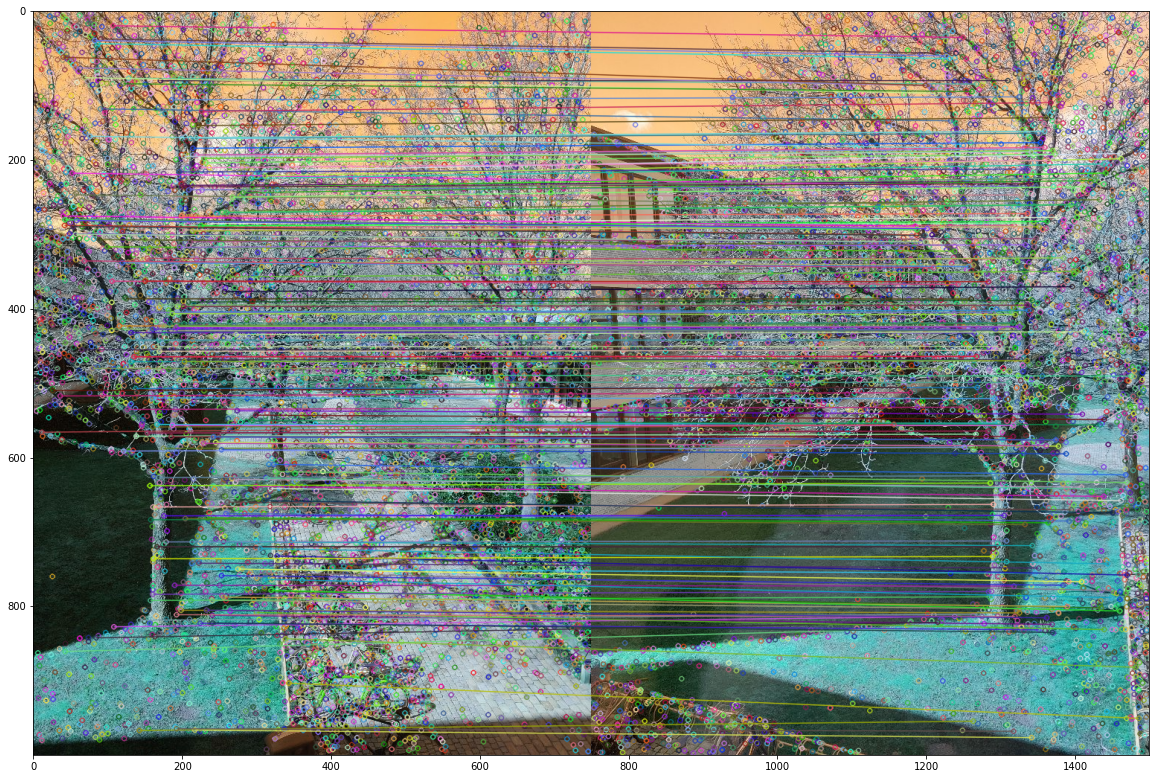

In [6]:
plt.figure(figsize=(20,20))
plt.imshow(cv2.drawMatches(im1, kp, im2, kp2, np.array(matches)[inlier_indices], None))

In [7]:
# 10.4
def warpImage(im, H, xRange, yRange):
    T = np.eye(3)
    T[:2, 2] = [-xRange[0], -yRange[0]]
    H = T@H
    outSize = (xRange[1]-xRange[0], yRange[1]-yRange[0])
    imWarp = cv2.warpPerspective(im, H, outSize)
    maskWarp = cv2.warpPerspective(np.ones(im.shape[:2], dtype=np.uint8), H, outSize)
    return imWarp, maskWarp

In [79]:
xRange = [0, im1.shape[1]+1000]
yRange = [0, im1.shape[0]]
imwarp1,maskwarp1 = warpImage(im1,Hest,xRange,yRange)
imwarp2,maskwarp2 = warpImage(im2,np.eye(3),xRange,yRange)

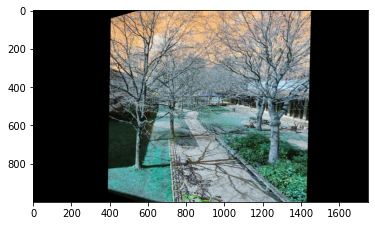

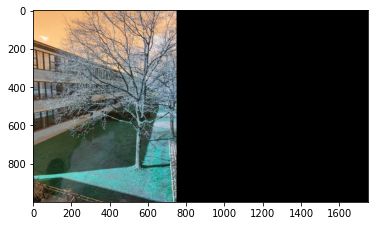

In [81]:
plt.imshow(imwarp1)
plt.figure(2)
plt.imshow(imwarp2)

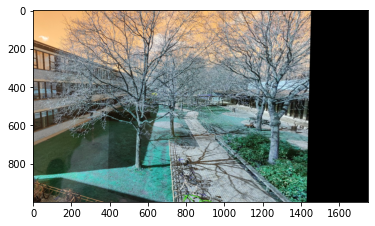

In [116]:
stitched = imwarp2.astype(np.float16)+imwarp1.astype(np.float16)
for i in range(stitched.shape[0]):
    for j in range(stitched.shape[1]):
        if maskwarp1[i,j] and maskwarp2[i,j]:
            stitched[i,j] /= 2
plt.figure(figsize=(20,20))
plt.imshow(stitched.astype(np.uint8))